# Exercises:
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


### Counting approach for trigrams

In [71]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
chars

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0

itos = {i:s for s,i in stoi.items()}
itos

import torch
N = torch.zeros((27,27,27), dtype=torch.int32)

for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1



In [72]:
g = torch.Generator().manual_seed(2147483647)

In [73]:
P = (N+1).float()
P /= P.sum(2, keepdim=True)

In [74]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    ix = 0
    iy = 0
    out = []
    while True:
        p = P[ix, iy, :]
        #p = N[ix].float()
        #p = p / p.sum()
        
        iz = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[iz])
        ix = iy
        iy = iz
        if iz == 0:
            break

    print(''.join(out))

ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.
moriellavojkwuthda.
kaley.
maside.
en.
aviyah.
fobspihiliven.
tahlasuzusfxx.
an.
glhpynn.
isan.


In [75]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1, ix2, ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-504653.)
nll=tensor(504653.)
nll/n=tensor(2.2120)


### Neural net approach for trigrams

In [76]:
chars = sorted(list(set(''.join(words))))
chars

# want an encoding for bigrams
# input to NN has length 27*27
b = [ch1+ch2 for ch1 in ['.']+chars for ch2 in ['.']+chars]
btoi = {b:i for i,b in enumerate(b)} # bigram to integer


stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0


itos = {i:s for s,i in stoi.items()}


In [80]:
xs, ys = [], []
for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        b = ch1 + ch2
        ib = btoi[b]
        iy = stoi[ch3]
        xs.append(ib)
        ys.append(iy)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((729, 27), generator = g, requires_grad=True)

number of examples:  228146


In [81]:
import torch.nn.functional as F

In [120]:
for k in range(50):
    # forward pass
    xenc = F.one_hot(xs, num_classes=729).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)
    loss = -probs[torch.arange(num), ys].log().mean() #  + 0.0001*(W**2).mean()
    
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += - 100* W.grad

print(loss.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (228146x729 and 27x27)

In [ ]:
# sampling
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = ['.', '.']
    ix = btoi['..']
    while True:
        ix = ''.join(out[-2:])
        ix = btoi[''.join(out[-2:])]
        xenc = F.one_hot(torch.tensor([ix]), num_classes=729).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        
        
        ix = torch.multinomial(p, num_samples=1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        

    print(''.join(out))




E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?



In [ ]:
# skipped

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. 
try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [121]:
# skipped

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [ ]:
ix = btoi['nl'] # test bigram
logits1 = W[ix, :]

xenc = F.one_hot(torch.tensor([ix]), num_classes=729).float()
logits2 = xenc @ W

logits1 == logits2

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [ ]:
# maybe different gradients make a difference for the backpropagation/weights updating step
# run pytoch examples
# try to figure out where log's are missing to get the same results
# write down pytorch formulas for special case
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

### Cross entropy

In [ ]:
# Cross entropy
# Example where target contains class indices
# This is case 1 in
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# "Note that this case is equivalent to the combination of LogSoftmax and NLLLoss."
import torch
import torch.nn as nn
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)        # 3 rows 5 cols sampled from standard normal distribution
target = torch.empty(3, dtype=torch.long).random_(5) # length 3 vector of random integers uniform in [0, 5)
output = loss(input, target)

In [ ]:
print(input)
print(target)
print(output)

In [ ]:
# softmax on rows for class probabilities
classprobs = input.exp() / input.exp().sum(1, keepdims=True) # or just input.softmax(dim=1)
classprobs

In [ ]:
-classprobs[torch.arange(3), target].log().mean()

In [ ]:
# Example of target with class probabilities
input2 = torch.randn(3, 5, requires_grad=True)
target2 = torch.randn(3, 5).softmax(dim=1)
output2 = loss(input2, target2)
output2.backward()

In [ ]:
print(input2)
print(target2)
print(output2)

In [ ]:
-(input2.softmax(dim=1).log() * target2).sum(dim=1).mean()
# this takes into account all probabilities, 
# not only the probabilities of the most likely class (uses more information than the first case)

### Negative log likelihood

In [ ]:
m = nn.LogSoftmax(dim=1) # m(input3) is numerically the same as input3.softmax(dim=1).log()
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input3 = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target3 = torch.tensor([1, 0, 4])
output3 = loss(m(input3), target3)
output3.backward()


In [ ]:
print(input3)
print(m(input3))
print(target3)
print(output3)

In [ ]:
# LogSoftmax is literally softmax().log() (at least for this example)
input3.softmax(dim=1).log()

In [ ]:
-m(input3)[torch.arange(3), target3].mean()

In [131]:
# 2D loss example (used, for example, with image inputs)
N, C = 5, 4
loss = nn.NLLLoss()
# input is standard normally distributed 
# of size N x C x height x width (N examples, C colors or classes (?), image height and image width)
data = torch.randn(N, 16, 10, 10) # it says C but C is 4, and here input is 16
conv = nn.Conv2d(16, C, (3, 3)) # something like: 16 colors in, C = 4 classes out, connect squares of size 3 by 3 pixels
m = nn.LogSoftmax(dim=1)
# each element in target has to have 0 <= integer classes value < C
# output from conv has dimension 10 - (3-1) = 8, the number of different (but overlapping) 'windows' of length 3
target4 = torch.empty(N, 8, 8, dtype=torch.long).random_(0, C)
output4 = loss(m(conv(data)), target4) # how does loss know the appropriate dimensions to for each operation?
output4.backward()

In [135]:
N

5

In [ ]:
nll = 0
for n in range(5):
    for h in range(8):
        for w in range(8):
            targetclass = target4[n, h, w]
            target = m(conv(data))[n, targetclass, h, w]
            nll += target
print(-nll/(5*8*8))

E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [ ]:
# Ideas:
# - visualization of 100 gradient descent operations on the weight matrix
# - reprogram Conv2d layer for an example in tinygrad terminology using Value class
# - python script to github (own makemore babylm)

In [114]:
## visualization of 100 gradient descent operations on the weight matrix
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad=True)

number of examples:  228146


In [117]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import imageio.v3 as iio

2.4728763103485107


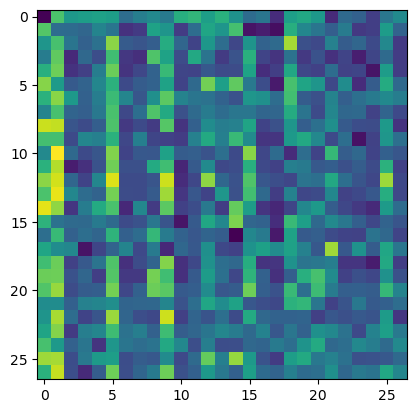

In [118]:
n = 100
for k in range(n):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True)
    loss = -probs[torch.arange(num), ys].log().mean()#  + 0.01*(W**2).mean()
    
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += - 50* W.grad
    
    plt.imshow(W.data.numpy())
    plt.savefig(f"{k}.jpg")

print(loss.item())

In [119]:
frames = np.stack([iio.imread(f"{k}.jpg") for k in range(n)], axis=0)
iio.imwrite("weightmatrix.gif", frames)

<img src="weightmatrix.gif" width="750" align="center">

In [144]:
# reprogram Conv2d layer for an example in tinygrad terminology using Value class
# I do it from scratch
input = torch.randn(5, 16, 10, 10)
conv = nn.Conv2d(16, 4, (3, 3))
output = conv(input)

In [145]:
print('input.shape: ', input.shape)
print('output.shape: ', output.shape)
print('conv.bias.shape: ', conv.bias.shape)
print('conv.weight.shape: ', conv.weight.shape)

input.shape:  torch.Size([5, 16, 10, 10])
output.shape:  torch.Size([5, 4, 8, 8])
conv.bias.shape:  torch.Size([4])
conv.weight.shape:  torch.Size([4, 16, 3, 3])


In [169]:
output[0,0,:,:] # N = 1, C_out = 1, one entry of an 8 by 8 tensor

tensor([[-1.0089, -0.4342,  0.0485, -0.0622, -0.2543,  0.1707,  0.0696,  0.3200],
        [-0.9803,  0.3918,  1.3116, -1.3458, -1.2828, -0.1525, -0.1725,  0.3693],
        [ 0.3952,  0.4548, -0.2557, -0.3474, -0.1778,  0.0699, -0.3526,  0.4009],
        [-0.3194, -0.1142, -0.9993,  0.4916,  0.1896, -0.4053, -0.9748, -0.6431],
        [-0.0151,  0.1367,  0.3428, -0.0445,  0.7619, -0.5679, -0.0166,  0.1496],
        [ 0.0639,  0.4096,  0.0959,  0.7384, -0.7021, -0.1635, -0.6977,  0.1653],
        [ 0.0325,  1.0574,  0.6667, -0.3198, -0.7068, -0.2384, -0.2920, -0.2000],
        [-0.9656,  0.2653, -0.0128,  0.7089, -0.6193, -0.0621,  0.3900, -0.2225]],
       grad_fn=<SliceBackward0>)

In [168]:
# hardcoded dimensions tensor1 3,3 and tensor2 10,10
# note that tensor[1,1,:,:] has shape of length 2, not 4 (dimensions are dropped by default)
# output has hardcoded dimension 8,8
def crosscorr(tensor1, tensor2):
    outtensor = torch.zeros(8,8)
    for irow in range(8):
        for icol in range(8):
            tensor1expanded = torch.zeros(10,10)
            tensor1expanded[irow:(irow+3), icol:(icol+3)] = tensor1
            outvalue = (tensor1expanded * tensor2).sum()
            outtensor[irow, icol] = outvalue
    return outtensor

In [167]:
# This calculation reproduces the 2d convolution for output channel c_out=1 of 4 and sample n=1 of 5
out = torch.zeros(8,8)
out += conv.bias[0] # start with bias, same for all entries in the 8 by 8 matrix
c_out = 0
n = 0
for k in range(16):
    out += crosscorr(conv.weight[n, k, :, :], input[n, k, :, :])
print(out)

tensor([[-1.0089, -0.4342,  0.0485, -0.0622, -0.2543,  0.1707,  0.0696,  0.3200],
        [-0.9803,  0.3918,  1.3116, -1.3458, -1.2828, -0.1525, -0.1725,  0.3693],
        [ 0.3952,  0.4548, -0.2557, -0.3474, -0.1778,  0.0699, -0.3526,  0.4009],
        [-0.3194, -0.1142, -0.9993,  0.4916,  0.1896, -0.4053, -0.9748, -0.6431],
        [-0.0151,  0.1367,  0.3428, -0.0445,  0.7619, -0.5679, -0.0166,  0.1496],
        [ 0.0639,  0.4096,  0.0959,  0.7384, -0.7021, -0.1635, -0.6977,  0.1653],
        [ 0.0325,  1.0574,  0.6667, -0.3198, -0.7068, -0.2384, -0.2920, -0.2000],
        [-0.9656,  0.2653, -0.0128,  0.7089, -0.6193, -0.0621,  0.3900, -0.2225]],
       grad_fn=<AddBackward0>)


Note that the first sum in https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html for the definition of the 2d convolution is meant to be tensors. Everything has dimension 8 (in this example this is the number of output 'channels').

The link to Wikipedia for the definition of cross-correlation was not helpful to me. I guessed that it is this sliding sum over the product of (kernel-)weights times the data (thus has dimension 8 by 8, because you can fit 8 non-overlapping blocks of size 3 in something of length 10).

The very end of the documentation for 2dConv shows how to access the weights and biasses (conv.weight and conv.bias).

The final convolution is the average (or rather: sum) of the individual cross-correlations.

Note that the gradient information does not match (slice vs add backward). What does this mean?

Open question for me: What is the interpretation of 'channels'? Is it 'number of grayscale colors' for input channels) and 'number of classes' for output channels? Then each entry in the convolution is the average of all colors and all points in the immediate vincinity of a given pixel?